<a href="https://colab.research.google.com/github/anugrahatY/RaspberryPunch/blob/main/Experiment/LigthBGM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [97]:
# Install latest LightGBM
!pip install --upgrade lightgbm

import lightgbm as lgb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
import joblib

In [98]:
# ==============================
# STEP 1: Load and clean dataset
# ==============================
df = pd.read_csv("/content/drive/MyDrive/linked_farm_dataset_extended.csv", parse_dates=["time"])
df = df.replace([np.inf, -np.inf], np.nan)
df = df.dropna(subset=["Generation_MW", "Irradiance_Wm2", "Temp_C"])

# Remove extreme outliers
upper_limit = df["Generation_MW"].quantile(0.99)
df = df[df["Generation_MW"] <= upper_limit]

# Sort by time
df = df.sort_values("time").reset_index(drop=True)

In [99]:
# ==============================
# STEP 2: Feature Engineering
# ==============================
# Lag features
df["Gen_lag1"] = df["Generation_MW"].shift(1)
df["Gen_lag2"] = df["Generation_MW"].shift(2)
df["Gen_lag3"] = df["Generation_MW"].shift(3)
df["Gen_lag6"] = df["Generation_MW"].shift(6)
df["Gen_lag24"] = df["Generation_MW"].shift(24)

# Rolling mean features
df["Gen_roll3"] = df["Generation_MW"].shift(1).rolling(3).mean()
df["Gen_roll24"] = df["Generation_MW"].shift(1).rolling(24).mean()

# Rolling std features
df["Gen_roll3_std"] = df["Generation_MW"].shift(1).rolling(3).std()
df["Gen_roll24_std"] = df["Generation_MW"].shift(1).rolling(24).std()

# Time-based features
df["hour"] = df["time"].dt.hour
df["hour_sin"] = np.sin(2 * np.pi * df["hour"] / 24)
df["hour_cos"] = np.cos(2 * np.pi * df["hour"] / 24)
df["month"] = df["time"].dt.month
df["weekday"] = df["time"].dt.weekday
df["is_weekend"] = df["weekday"].isin([5,6]).astype(int)

# Drop rows with NaNs from lag/rolling calculations
feature_cols = [
    "Gen_lag1","Gen_lag2","Gen_lag3","Gen_lag6","Gen_lag24",
    "Gen_roll3","Gen_roll24","Gen_roll3_std","Gen_roll24_std",
    "hour_sin","hour_cos","month","weekday","is_weekend",
    "Irradiance_Wm2","ClearSky_Index","Temp_C","Humidity_pct",
    "WindSpeed_mps","Precipitation_mm"
]
df = df.dropna(subset=feature_cols)

# ==============================
# STEP 3: Train/Test Split
# ==============================
split_idx = int(len(df) * 0.7)
train_df = df.iloc[:split_idx]
test_df = df.iloc[split_idx:]

X_train = train_df[feature_cols]
y_train = train_df["Generation_MW"]

X_test = test_df[feature_cols]
y_test = test_df["Generation_MW"]
time_test = test_df["time"]


In [100]:
# ==============================
# STEP 4: Train LightGBM
# ==============================
gbm = lgb.LGBMRegressor(
    objective='regression',
    learning_rate=0.07,
    num_leaves=52,
    max_depth=13,
    feature_fraction=0.7,
    bagging_fraction=0.71,
    bagging_freq=4,
    min_child_samples=86,
    lambda_l1=4.56,
    lambda_l2=2.05,
    n_estimators=1500,
    min_split_gain=0.005,
    random_state=42,
    verbosity=-1
)

gbm.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    eval_names=['train','valid'],
    callbacks=[lgb.early_stopping(stopping_rounds=50, verbose=50)]
)


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[74]	train's l2: 1.84682	valid's l2: 5.16054


LGBMRegressor(bagging_fraction=0.71, bagging_freq=4, feature_fraction=0.7,
              lambda_l1=4.56, lambda_l2=2.05, learning_rate=0.07, max_depth=13,
              min_child_samples=86, min_split_gain=0.005, n_estimators=1500,
              num_leaves=52, objective='regression', random_state=42,
              verbosity=-1)

✅ LightGBM Results (Overall)
RMSE: 2.27 MW
R²: 0.950

📊 Feature Importance Table:
         Feature  Gain Importance  Split Importance
        Gen_lag1     1.896908e+06               203
       Gen_lag24     8.513645e+05               114
        hour_sin     7.708563e+05               131
        hour_cos     2.223562e+05                40
       Gen_roll3     1.612536e+05                54
   Gen_roll3_std     5.235311e+04               107
        Gen_lag2     4.376945e+04                41
        Gen_lag6     3.280972e+04                59
  Irradiance_Wm2     2.089460e+04                23
  Gen_roll24_std     1.526777e+04                42
      Gen_roll24     8.894784e+03                31
Precipitation_mm     4.987735e+03                21
        Gen_lag3     4.588402e+03                41
  ClearSky_Index     3.909022e+03                50
    Humidity_pct     2.909852e+03                39
           month     9.039492e+02                26
          Temp_C     8.221353e+02 

<Figure size 800x600 with 0 Axes>

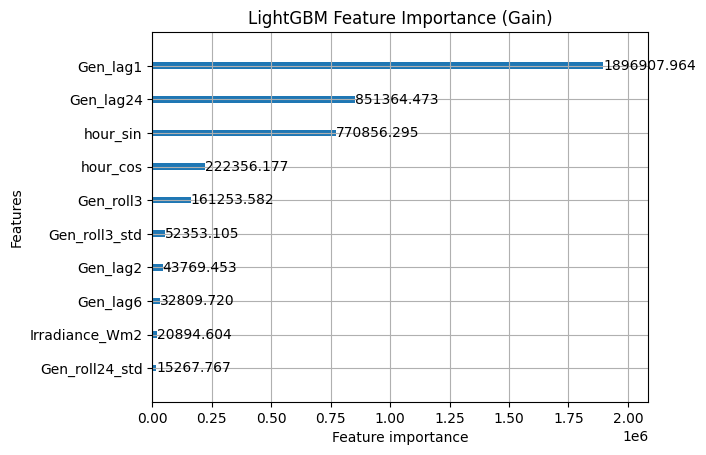


📊 Seasonal Performance (by month):
Month 07 → RMSE=2.09, R²=0.941
Month 08 → RMSE=2.26, R²=0.954
Month 09 → RMSE=2.40, R²=0.948


In [102]:
# ==============================
# STEP 5: Predictions & Evaluation
# ==============================
y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration_)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print("✅ LightGBM Results (Overall)")
print(f"RMSE: {rmse:.2f} MW")
print(f"R²: {r2:.3f}")

# ==============================
# STEP 6: Feature Importance
# ==============================
importance_df = pd.DataFrame({
    "Feature": X_train.columns,
    "Gain Importance": gbm.booster_.feature_importance(importance_type="gain"),
    "Split Importance": gbm.booster_.feature_importance(importance_type="split")
}).sort_values(by="Gain Importance", ascending=False)

print("\n📊 Feature Importance Table:")
print(importance_df.to_string(index=False))

plt.figure(figsize=(8,6))
lgb.plot_importance(gbm, max_num_features=10, importance_type="gain")
plt.title("LightGBM Feature Importance (Gain)")
plt.show()

# ==============================
# STEP 7: Seasonal Performance
# ==============================
test_results = pd.DataFrame({
    "time": time_test,
    "actual": y_test,
    "predicted": y_pred
})
test_results["month"] = test_results["time"].dt.month

print("\n📊 Seasonal Performance (by month):")
for month in sorted(test_results["month"].unique()):
    subset = test_results[test_results["month"] == month]
    rmse_m = np.sqrt(mean_squared_error(subset["actual"], subset["predicted"]))
    r2_m = r2_score(subset["actual"], subset["predicted"])
    print(f"Month {month:02d} → RMSE={rmse_m:.2f}, R²={r2_m:.3f}")

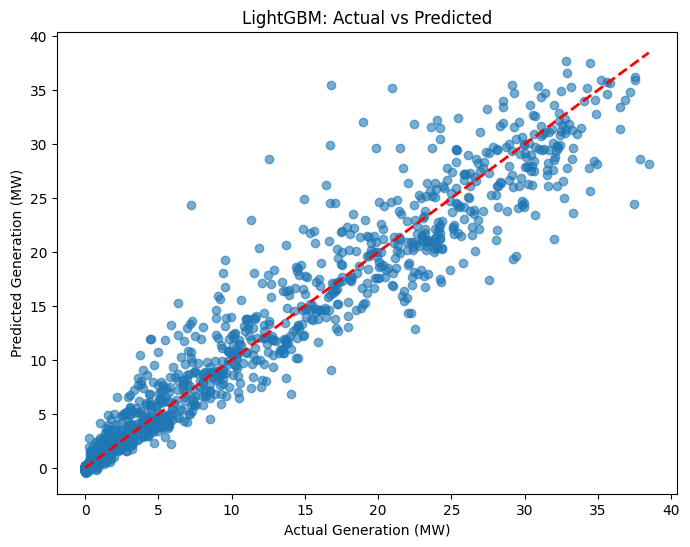

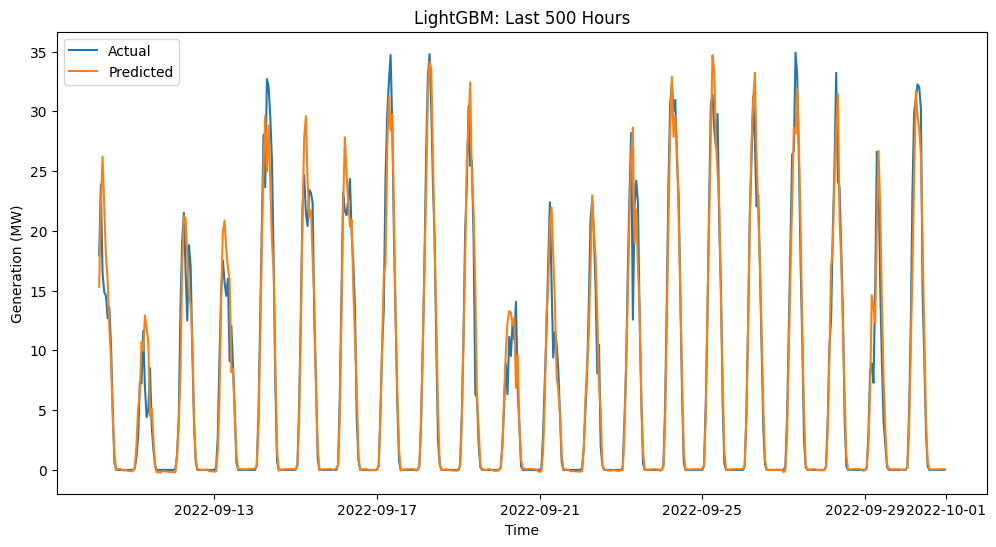

In [103]:
# ==============================
# STEP 8: Visualizations
# ==============================
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--", lw=2)
plt.xlabel("Actual Generation (MW)")
plt.ylabel("Predicted Generation (MW)")
plt.title("LightGBM: Actual vs Predicted")
plt.show()

plt.figure(figsize=(12,6))
plt.plot(time_test.iloc[-500:], y_test.iloc[-500:], label="Actual")
plt.plot(time_test.iloc[-500:], y_pred[-500:], label="Predicted")
plt.xlabel("Time")
plt.ylabel("Generation (MW)")
plt.title("LightGBM: Last 500 Hours")
plt.legend()
plt.show()


In [104]:
# ==============================
# STEP 9: Save Model
# ==============================
joblib.dump(gbm, "solar_lgbm_model.pkl")
print("✅ Model saved as 'solar_lgbm_model.pkl'")

✅ Model saved as 'solar_lgbm_model.pkl'


In [ ]:
# ==============================
# Hyperparameter Tuning with Optuna
# ==============================
# !pip install optuna

# import optuna
# import lightgbm as lgb
# from sklearn.metrics import mean_squared_error
# import numpy as np

# def objective(trial):
#     params = {
#         "objective": "regression",
#         "metric": "rmse",
#         "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.2),
#         "num_leaves": trial.suggest_int("num_leaves", 20, 150),
#         "max_depth": trial.suggest_int("max_depth", 3, 20),
#         "feature_fraction": trial.suggest_float("feature_fraction", 0.6, 1.0),
#         "bagging_fraction": trial.suggest_float("bagging_fraction", 0.6, 1.0),
#         "bagging_freq": trial.suggest_int("bagging_freq", 1, 10),
#         "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
#         "lambda_l1": trial.suggest_float("lambda_l1", 0.0, 5.0),
#         "lambda_l2": trial.suggest_float("lambda_l2", 0.0, 5.0),
#         "random_state": 42,
#         "n_estimators": 1000
#     }

#     model = lgb.LGBMRegressor(**params)

#     # Fit with early stopping
#     model.fit(
#         X_train, y_train,
#         eval_set=[(X_test, y_test)],
#         callbacks=[lgb.early_stopping(stopping_rounds=50, verbose=False)]
#     )

#     y_pred = model.predict(X_test, num_iteration=model.best_iteration_)
#     rmse = np.sqrt(mean_squared_error(y_test, y_pred))
#     return rmse

# # Create study and optimize
# study = optuna.create_study(direction="minimize")
# study.optimize(objective, n_trials=50)  # adjust n_trials for more thorough search

# # Display best parameters and RMSE
# print("✅ Best Hyperparameters Found:")
# for key, value in study.best_trial.params.items():
#     print(f"{key}: {value}")
# print(f"Best Validation RMSE: {study.best_trial.value:.3f}")
